In [1]:
import pandas as pd
df = pd.read_csv('machine failure.csv')

X = df.drop(columns=['Machine failure'])
y = df['Machine failure']

In [2]:
df_cleaned = pd.get_dummies(df, columns=['Type'])
print(df.head())

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0  

特徵工程

In [3]:
import numpy as np

# 溫差：製程溫度 - 空氣溫度
df_cleaned['Temperature difference'] = df_cleaned['Process temperature [K]'] - df_cleaned['Air temperature [K]']

# 功率計算：Torque × RPM × (2π / 60)
df_cleaned['Power'] = df_cleaned['Torque [Nm]'] * df_cleaned['Rotational speed [rpm]'] * (2 * np.pi / 60)

# 扭力每轉速
df_cleaned['Torque per RPM'] = df_cleaned['Torque [Nm]'] / df_cleaned['Rotational speed [rpm]']

# 磨損每轉速
df_cleaned['Wear per RPM'] = df_cleaned['Tool wear [min]'] / df_cleaned['Rotational speed [rpm]']

# 溫度比：空氣溫度 / 製程溫度
df_cleaned['Temperature ratio'] = df_cleaned['Air temperature [K]'] / df_cleaned['Process temperature [K]']

Machine failure預測

只保留前五重要特徵並將預測準確率改為f1score

✅ 最佳參數：{'ccp_alpha': 0.005, 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 10}
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      9661
           1       0.31      0.92      0.47       339

    accuracy                           0.93     10000
   macro avg       0.65      0.92      0.71     10000
weighted avg       0.97      0.93      0.95     10000

訓練 F1-score：0.954
驗證 F1-score（交叉驗證）：0.716


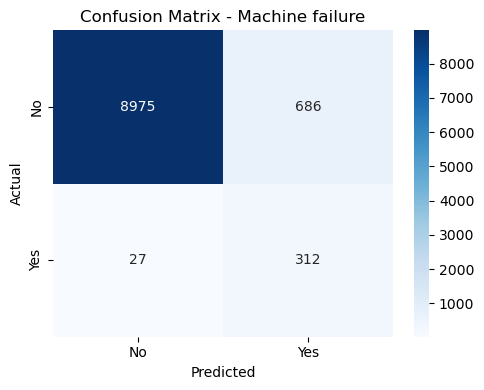

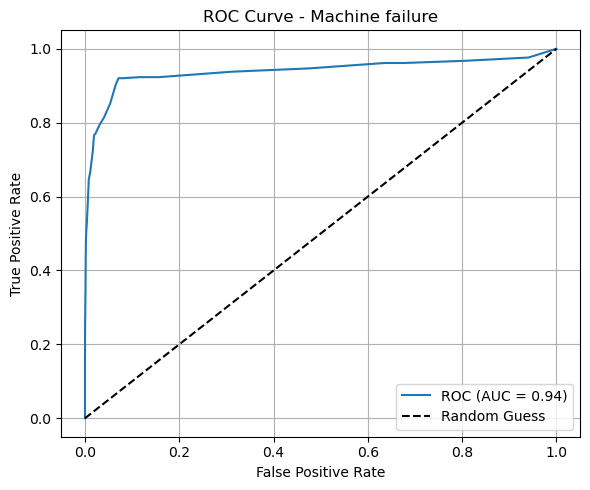

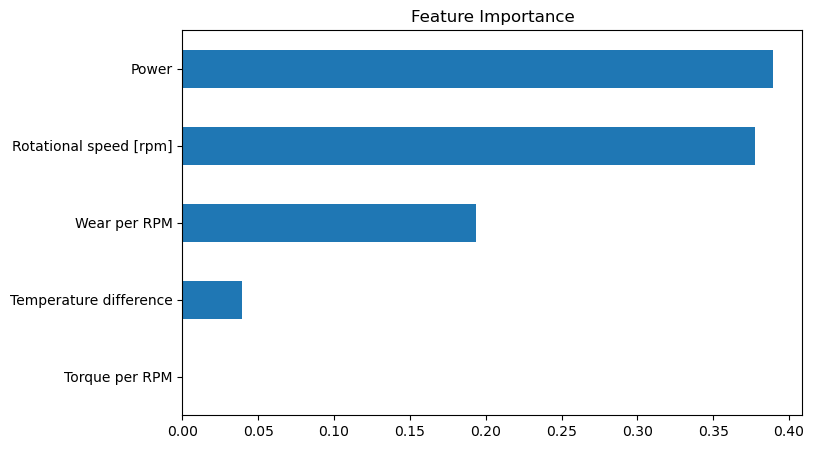

In [4]:
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ====== 💡 參數設定區 ======
features = ['Rotational speed [rpm]', 
             'Temperature difference', 'Power',
            'Torque per RPM', 'Wear per RPM']
failures = ['Machine failure']

# 強化剪枝限制 + 控制模型複雜度
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [10, 20],
    'ccp_alpha': [0.005, 0.01, 0.02, 0.05]
}

sampler = BorderlineSMOTE(sampling_strategy=0.1, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ====== 🚀 執行流程 ======
X_raw = df_cleaned[features]
y_raw = df_cleaned['Machine failure'].astype(int)

# 特徵標準化（雖然對決策樹影響不大，但可保留）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# BorderlineSMOTE 後處理
X_resampled, y_resampled = X_scaled, y_raw

# GridSearchCV 尋找最佳參數，評分改為 f1_macro
grid_search = GridSearchCV(
    DecisionTreeClassifier(class_weight='balanced', random_state=42),
    param_grid,
    cv=skf,
    scoring='f1_macro'
)
grid_search.fit(X_resampled, y_resampled)
best_params = grid_search.best_params_

print(f"✅ 最佳參數：{best_params}")

# 訓練最終模型
final_model = DecisionTreeClassifier(class_weight='balanced', **best_params, random_state=42)
final_model.fit(X_resampled, y_resampled)

# 模型預測
y_pred_prob = cross_val_predict(final_model, X_resampled, y_resampled, cv=skf, method='predict_proba')[:, 1]
y_pred = (y_pred_prob >= 0.5).astype(int)

# 分類報告
print(classification_report(y_resampled, y_pred))

# 訓練 vs 驗證效果比對（檢查是否仍過擬合）
train_f1 = classification_report(y_resampled, final_model.predict(X_resampled), output_dict=True)['weighted avg']['f1-score']
val_f1 = cross_val_score(final_model, X_resampled, y_resampled, cv=skf, scoring='f1_macro').mean()
print(f"訓練 F1-score：{train_f1:.3f}")
print(f"驗證 F1-score（交叉驗證）：{val_f1:.3f}")

# 混淆矩陣
cm = confusion_matrix(y_resampled, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f'Confusion Matrix - Machine failure')
plt.tight_layout()
plt.show()

# ROC 曲線
fpr, tpr, _ = roc_curve(y_resampled, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f'ROC Curve - Machine failure')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# 特徵重要性視覺化
importance = pd.Series(final_model.feature_importances_, index=features)
importance.sort_values(ascending=True).plot.barh(figsize=(8, 5), title="Feature Importance")
plt.show()

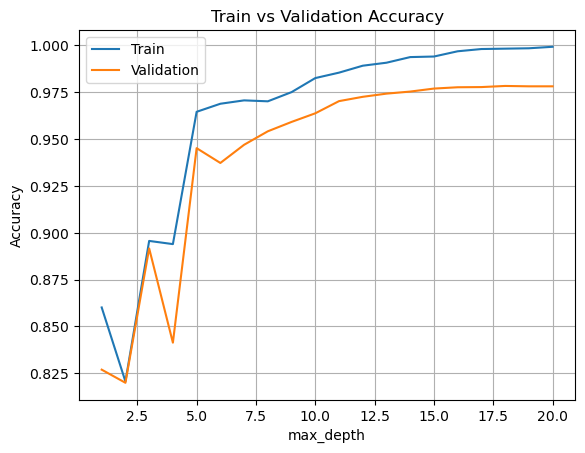

In [5]:
train_scores = []
val_scores = []
depth_range = range(1, 21)

for d in depth_range:
    model = DecisionTreeClassifier(class_weight='balanced', max_depth=d, random_state=42)
    model.fit(X_resampled, y_resampled)
    train_scores.append(model.score(X_resampled, y_resampled))
    val_scores.append(cross_val_score(model, X_resampled, y_resampled, cv=5).mean())

plt.plot(depth_range, train_scores, label='Train')
plt.plot(depth_range, val_scores, label='Validation')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()
